In [1]:
# # # Run the following command in the terminal to install necessary dependencies (seems like need to install in this order to work properly)
# # # Actually I am not sure if these are actually working, but the ideas are we need the dependencies from these branches
# ! pip install git+ssh://git@github.com/aws/amazon-braket-schemas-python.git@quera 
# ! pip install git+ssh://git@github.com/aws/amazon-braket-sdk-python.git@feature/ahs-local-sim
# ! pip install git+ssh://git@github.com/aws/amazon-braket-default-simulator-python-staging.git@feature/neutral-atom-simulator-solvers


  Cloning ssh://****@github.com/aws/amazon-braket-schemas-python.git (to revision quera) to /private/var/folders/17/wqjdf0nn4dj11p1h8yrx44100000gr/T/pip-req-build-bg2u6d4i
  Running command git clone -q 'ssh://****@github.com/aws/amazon-braket-schemas-python.git' /private/var/folders/17/wqjdf0nn4dj11p1h8yrx44100000gr/T/pip-req-build-bg2u6d4i
  Running command git checkout -b quera --track origin/quera
  Switched to a new branch 'quera'
  branch 'quera' set up to track 'origin/quera'.
  Resolved ssh://****@github.com/aws/amazon-braket-schemas-python.git to commit 306328d675bf3f7b139b146bbda5c2842655b577
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning ssh://****@github.com/aws/amazon-braket-sdk-python.git (to revision feature/ahs-local-sim) to /private/var/folders/17/wqjdf0nn4dj11p1h8yrx44100000gr/T/pip-req-build-yrs5une5
  Running command git clone -q 'ssh://****@github.com/aws/amazon-braket-sdk-pyth

    Preparing wheel metadata ... done
  Cloning ssh://****@github.com/aws/amazon-braket-schemas-python (to revision quera) to /private/var/folders/17/wqjdf0nn4dj11p1h8yrx44100000gr/T/pip-install-z2ec3255/amazon-braket-schemas_bef3cc96357b43e38054fc40290b2588
  Running command git clone -q 'ssh://****@github.com/aws/amazon-braket-schemas-python' /private/var/folders/17/wqjdf0nn4dj11p1h8yrx44100000gr/T/pip-install-z2ec3255/amazon-braket-schemas_bef3cc96357b43e38054fc40290b2588
  Running command git checkout -b quera --track origin/quera
  Switched to a new branch 'quera'
  branch 'quera' set up to track 'origin/quera'.
  Resolved ssh://****@github.com/aws/amazon-braket-schemas-python to commit 306328d675bf3f7b139b146bbda5c2842655b577
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


# Ordered phases in rydberg systems

In this example notebook, we will introduce the ordered phases in Rydberg systems, with focus on the 1D $Z_2$ phase and the 2D checkerboard phase.

## Introduction of Rydberg Hamiltonian


## Adiabatic evolution

We begin by importing the necessary packages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from braket.ahs.atom_arrangement import AtomArrangement

from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from utils import show_register, show_global_drive, show_final_avg_density, get_drive

from braket.devices import LocalSimulator

## 1D $Z_2$ phase 

Here we consider a 1D chain of 9 atoms with neighboring atoms separated by $5.5\mu m$. The setup of the system can be generated as follows

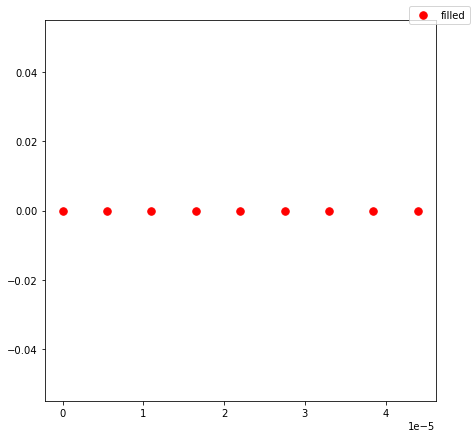

In [3]:
register = AtomArrangement()
separation = 5.5e-6  # in meters 
num_atoms = 9

for k in range(num_atoms):
    register.add((k*separation, 0))
    
show_register(register)

Let us plot the arrangment of the atoms and confirm that the setup is properly prepared. 

In order to prepare the $Z_2$ ordered state for the atomic chain, we shall design an analog Hamiltonian simulation  (AHS) program that drives the system adiabatically. The program consists three parts: the amplitude and phase of the Rabi frequency and the detuning. They can be specified as follows.

In [4]:
amplitude_min = 0       
amplitude_max = 24e6
detuning_min = -24e6
detuning_max = 60e6

time_max = 4e-6
time_ramp = 5e-7

time_points = [0, time_ramp, time_max - time_ramp, time_max]
amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]


drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)

We can plot the waveforms of these driving fields to make sure that they are correctly specified.

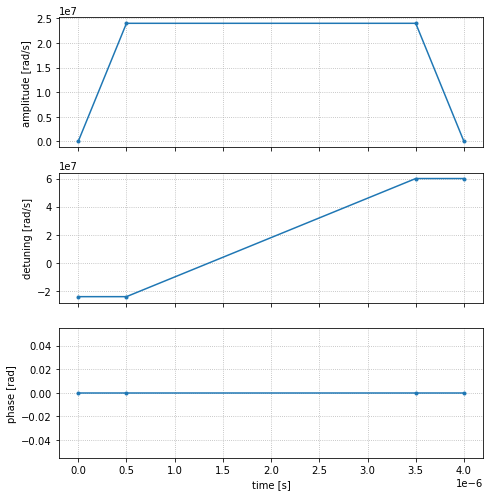

In [5]:
show_global_drive(drive)

Finally the AHS program of interest is the collection of the atomic registers, and the Hamiltonian defined above. 

In [6]:
ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)


Before runnig the program on Quera's device, we can first run it on the local simulator to make sure the outcome is the expected $Z_2$ state. 

Say sth about validation.

In [7]:
device = LocalSimulator("braket_ahs")

In [8]:
result = device.run(ahs_program, shots=100).result()

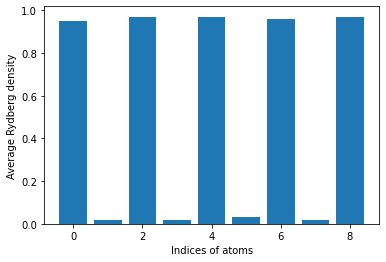

In [9]:
show_final_avg_density(result)

## 2D checkerboard phase 

In two dimension, Rydberg system can exhibit the checkerboard phase, which is analogues to the $Z_2$ phase in 1D. For simplicity, here we create a two dimensionl triangular atomic array. 

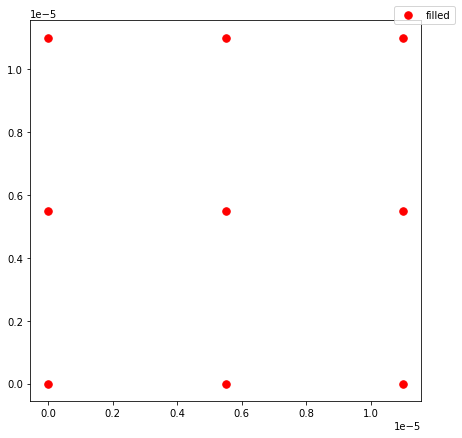

In [10]:
register_2D = AtomArrangement()
separation = 5.5e-6  # in meters 

for k in range(3):
    for l in range(3):
        register_2D.add((k * separation, l * separation))

show_register(register_2D)

Without loss of generality, we shall use the same Hamiltonian as the one used for realizing the $Z_2$ phase in the 1D atomic chain. 

In [11]:
ahs_program_2D = AnalogHamiltonianSimulation(
    register=register_2D, 
    hamiltonian=drive
)

result_2D = device.run(ahs_program_2D, shots=100).result()

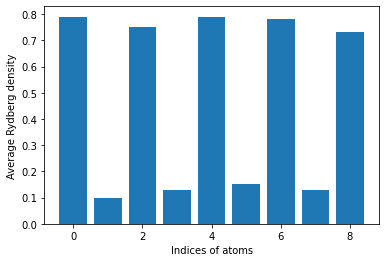

In [12]:
show_final_avg_density(result_2D)